# 99 Panel PSM Approach

### Install Relevant Libraries

In [1]:
# ! python -m pip install pandas numpy scikit-learn statsmodels matplotlib seaborn 
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'verdana'

### Constants

In [2]:
DATA_DIR = '../02 Data/'

YEAR_VAR = 'Year'
INDUSTRY_VAR = 'ff_12ind_name'
COUNTRY_VAR = 'geoln'
PANEL_ID_VAR = 'dscd'
PANEL_NAME_VAR = 'name'

OUTCOME_VAR = 'SusScorestandardized'
TREATMENT_VAR = 'ff'
COVARIATES = ['firmsize_l1_w', 'leverage_l1_w', 'assetstructure_l1_w', 'resdev_l1_w', 'salesgrowth_l1_w', 'log_age_l1_w']
ADDITIONAL_VARS = ['SustainabilityScore', 'SusScoreSquared', 'ifff', 'iicf', 'iodc', 'iwh',
                   'assets', 'roa2_l1_w', 
                   'FiveYearGrowth_w', 'p_pct_w', 'C_w', 'ValuetoEquity2_w',
                   'growthbinary', 'survivalbinary', 'riskbinary', 'valuebinary',
                   'tobinsq_w', 'mtb_w', 'log_tobinsq_w', 'log_mtb_w', 'ri', 'ri_lag', 'ri_ret',
                   'InstitutionalInvestor', 'Public', 'DirectInstitution', 'DirectNonInstitution',
                   'country']

PSCORE_METHOD = 'logit'  # or 'probit'
CALIPER = 0.05

FE_SUFFIX = '_fe'

RANDOM_STATE = 100
MAX_TRIES = 20

TREATMENT_COLOR = '#C00000'
CONTROL_COLOR = '#003359'

### Functions

In [3]:
def generate_all_fe_dummies(df, fe_vars, prefix_sep='|', suffix = '_fe'):
    """
    Adds dummy variables for all unique values of each fixed effect (FE) variable in fe_vars.
    No base is omitted; every category gets a dummy.
    
    Args:
        df: pandas DataFrame (not modified in-place).
        fe_vars: list of str, names of FE variables to dummy.
        prefix_sep: str, separator for dummy variable names.
    
    Returns:
        df_out: DataFrame with all FE dummies added.
    """
    df_out = df.copy()

    for var in fe_vars:
        for val in sorted(df_out[var].dropna().unique()):
            col_name = f"{var}{prefix_sep}{val}{suffix}"
            df_out[col_name] = (df_out[var] == val).astype(int)
            
    return df_out

In [4]:
def drop_fe_dummies_and_obs(X, y, fe_vars, base_dummy_locs=0, suffix = '_fe',verbose=True):
    """
    Drops specified dummy columns and their corresponding observations if there is no
    variation in the treatment variable when the dummy is 1.
    Optionally reports if a base dummy was dropped.

    Args:
        X: DataFrame (design matrix).
        y: Series, treatment variable aligned with X.
        dummy_cols: list of column names to check (default: all columns in X ending with '_fe')
        base_dummies: list of col names that correspond to a "base" category (optional)
        verbose: bool, print what is dropped

    Returns:
        X, y, dropped_bases (set of base dummies that were dropped)
    """

    drop_cols = []
    drop_obs_idx = set()
    dropped_bases = set()
    
    for var in fe_vars:
        dummy_cols = [col for col in X.columns if col.endswith(FE_SUFFIX) and var.startswith(var)]
        dummy_cols = sorted(dummy_cols)
        base_col = dummy_cols[base_dummy_locs]

        for col in dummy_cols:
            treat_in_group = y[X[col] == 1]
            unique_treats = treat_in_group.unique()
            
            if treat_in_group.nunique() < 2:  # always 1, always 0, or only 1 obs
                # For more explicit reporting:
                if len(treat_in_group) == 0:
                    detail = "No obs where dummy==1"
                
                elif unique_treats[0] == 1:
                    detail = "always 1"
                
                elif unique_treats[0] == 0:
                    detail = "always 0"
                
                else:
                    detail = f"singleton (val={unique_treats[0]})"
                
                if verbose:
                    print(f"Dropping {col}: Treatment {detail} when this dummy == 1")
                
                drop_cols.append(col)
                drop_obs_idx.update(X.index[X[col] == 1])
                
                if col == base_col:
                    dropped_bases.add(col)

    if drop_cols:
        if verbose:
            print(f"[INFO] Dropping dummies that perfectly predict treatment: {drop_cols}")
            
        X = X.drop(columns=drop_cols)
        
        if verbose:
            print(f"[INFO] Dropping {len(drop_obs_idx)} obs where dropped dummies were 1")
            
        X = X.drop(index=drop_obs_idx)
        y = y.drop(index=drop_obs_idx)

    return X, y, dropped_bases

In [5]:
def make_safe_column(col):
    # Replace problematic chars with underscores
    safe = col.replace('|', '_').replace(' ', '_')
    # Optionally, remove or replace other problematic chars here
    return safe

def build_manual_formula(outcome_var, covariates, dummy_cols, add_intercept=True, preview=False):
    """
    Builds a patsy formula using your own dummy variables (not C() notation).

    Args:
        outcome_var: str
        covariates: list of str
        dummy_cols: list of str
        add_intercept: bool (default True; use False and add '-1' to omit intercept)
    Returns:
        formula: str
    """
    terms = list(covariates) + list(dummy_cols)
    rhs = " + ".join(terms)
    
    if not add_intercept:
        rhs += " -1"

    formula = f"{outcome_var} ~ {rhs}"

    if preview == True:
        print(formula)
    
    return formula

### Script

##### Dataframe Preparation

In [6]:
df = pd.read_stata(f'{DATA_DIR}FF and FS Sample for PSM.dta').copy()
df['Year'] = pd.DatetimeIndex(df['year']).year
df = df.astype({'Year': 'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26223 entries, 0 to 26222
Columns: 337 entries, year to Year
dtypes: category(4), datetime64[ns](2), float32(202), float64(71), int16(5), int32(8), int64(1), int8(4), object(40)
memory usage: 44.3+ MB


In [7]:
### Final Preparation of Dataframe
years = sorted(df[YEAR_VAR].unique())
industries = sorted(df[INDUSTRY_VAR].unique())
countries = sorted(df[COUNTRY_VAR].unique())

df = generate_all_fe_dummies(df, [COUNTRY_VAR], suffix = FE_SUFFIX)

# Define relevant FE columns
fe_cols = [var for var in df.columns if var.endswith(FE_SUFFIX)]

### Set df with relevant variables
df = df[['dscd', 'name'] + [YEAR_VAR] + [INDUSTRY_VAR] + [COUNTRY_VAR] + [OUTCOME_VAR] + ADDITIONAL_VARS + [TREATMENT_VAR] + COVARIATES + sorted(fe_cols)]

# Rename columns in your DataFrame
# Adjust column names for spaces - patsy limitation
safe_col_dict = {col: make_safe_column(col) for col in fe_cols}
df = df.rename(columns=safe_col_dict)
fe_cols = [var for var in df.columns if var.endswith(FE_SUFFIX)]

##### Matching Approach

In [8]:
matched_rows = []
prior_matching_dfs = []

for year in sorted(df[YEAR_VAR].unique()):
    print(year)

    for industry in df[INDUSTRY_VAR].unique():
        print(industry)
        df_year_industry = df.loc[(df[YEAR_VAR] == year) & (df[INDUSTRY_VAR] == industry)].copy()
        print(f'Number of Year-Industry Observations (Pre-Clean): {len(df_year_industry)}')

        # Rename columns in your DataFrame
        df_year_industry = df_year_industry.rename(columns=safe_col_dict)
        
        # Create formula statement for Patsy
        formula = build_manual_formula(TREATMENT_VAR, COVARIATES, fe_cols, add_intercept=True)
        
        # Set sample variables based on fomula
        y, X = patsy.dmatrices(formula, data=df_year_industry, return_type='dataframe')
        y = y.iloc[:, 0]
        
        # Drop broken fixed effects dummies
        X, y, dropped_base_cases = drop_fe_dummies_and_obs(X, y, [COUNTRY_VAR], base_dummy_locs=0, verbose=True)
        print(dropped_base_cases)
        
        # Check if base case was dropped. If so, set new base case
        fe_vars = [COUNTRY_VAR]
        for var in fe_vars:
            base_case = [col for col in sorted(fe_cols) if col.endswith(FE_SUFFIX) and var.startswith(var)][0]
            new_dummy_cols = [col for col in sorted(X.columns) if col.endswith(FE_SUFFIX) and var.startswith(var)]
            
            if base_case not in new_dummy_cols:
                X = X.drop(columns=new_dummy_cols[-1]) # Drops the last sorted variable

            else:
                X = X.drop(columns = base_case)

        ### Skip specification in cases of too few observations
        if X.shape[0] <= 55:
            print('\n')
            continue
            
        # Estimate Logit Model
        model  = sm.Logit(y, X) if PSCORE_METHOD == 'logit' else sm.Probit(y,X)
        try:
            fit = model.fit(disp=0, maxiter=500)
        except:
            print("There is an issue!!!!!!!!!!!")
            print(X.shape[0])
        # print(fit.summary())

        df_year_industry['pscore'] = fit.predict(X)
        df_year_industry = df_year_industry.dropna(subset = ['pscore'])

        prior_matching_dfs.append(df_year_industry)

        
        # Implement Matching Procedure
        df_treated = df_year_industry[df_year_industry[TREATMENT_VAR]==1].copy()
        print(f'Len Treated Vars{len(df_treated)}')
        df_control = df_year_industry[df_year_industry[TREATMENT_VAR]==0].copy()
        print(f'Len Control Vars{len(df_control)}')

        df_treated = df_treated.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        df_control = df_control.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

        # Set to track which control indices have been matched (no replacement)
        matched_control_idx = set()

        print(f'Total treated Obs: {len(df_treated)}')
        for _, treat_row in df_treated.iterrows():
            available_controls = df_control.loc[~df_control.index.isin(matched_control_idx)]
            print(f'Remaining Controls: {len(available_controls)}')
            print(_)
    
            if available_controls.empty:
                print('Something Went Wrong - Not Enough Controls')
                continue  # No controls left to match

            # Calculate differences pscores for all combinations between given treatment obs and all possible controls
            abs_diffs = np.abs(available_controls['pscore'] - treat_row['pscore'])
            
            # Find controls within the caliper
            within_caliper = abs_diffs[abs_diffs <= CALIPER]

            if within_caliper.empty:
                # No suitable match found for this treated unit
                print(f"No control within caliper for treated id {treat_row[PANEL_ID_VAR]} (pscore={treat_row['pscore']:.3f})")
                continue
            
            min_idx = within_caliper.idxmin()
            control_row = available_controls.loc[min_idx]

            # Save match info: all relevant variables from treated and control
            match_info = {
                'match_year': year,
                'match_industry': industry,
                'treat_name': treat_row[PANEL_NAME_VAR],
                'control_name': control_row[PANEL_NAME_VAR],
                'treat_id': treat_row[PANEL_ID_VAR],
                'control_id': control_row[PANEL_ID_VAR],
                'treat_pscore': treat_row['pscore'],
                'control_pscore': control_row['pscore'],
                'absdiff': abs(treat_row['pscore'] - control_row['pscore'])
            }
            
            # Add Sustainability, additional variables, covariates for both groups
            for v in [OUTCOME_VAR] + ADDITIONAL_VARS + COVARIATES + [COUNTRY_VAR]:
                match_info[f'treat_{v}'] = treat_row[v]
                match_info[f'control_{v}'] = control_row[v]

            matched_rows.append(match_info)
            matched_control_idx.add(min_idx)  # Mark this control as used
            
        print('\n')

# ---- Compile all matched pairs into a DataFrame ----
df_matched = pd.DataFrame(matched_rows)
df_not_matched = pd.concat(prior_matching_dfs)

# ---- Save results ----
# df_matched.to_stata('matched_panel_sample.dta', write_index=False)
print(f'Number of Obs Matched Sample: {len(df_matched)}')
df_matched.head()

2007
BusEq
Number of Year-Industry Observations (Pre-Clean): 251
Dropping geoln_AUSTRIA_fe: Treatment always 1 when this dummy == 1
Dropping geoln_IRELAND_fe: Treatment always 0 when this dummy == 1
Dropping geoln_LUXEMBOURG_fe: Treatment No obs where dummy==1 when this dummy == 1
Dropping geoln_NETHERLANDS_fe: Treatment always 0 when this dummy == 1
Dropping geoln_NORWAY_fe: Treatment always 0 when this dummy == 1
Dropping geoln_SPAIN_fe: Treatment always 0 when this dummy == 1
Dropping geoln_SWEDEN_fe: Treatment always 0 when this dummy == 1
[INFO] Dropping dummies that perfectly predict treatment: ['geoln_AUSTRIA_fe', 'geoln_IRELAND_fe', 'geoln_LUXEMBOURG_fe', 'geoln_NETHERLANDS_fe', 'geoln_NORWAY_fe', 'geoln_SPAIN_fe', 'geoln_SWEDEN_fe']
[INFO] Dropping 27 obs where dropped dummies were 1
{'geoln_AUSTRIA_fe'}
Len Treated Vars69
Len Control Vars155
Total treated Obs: 69
Remaining Controls: 155
0
Remaining Controls: 154
1
Remaining Controls: 153
2
Remaining Controls: 152
3
Remaining 

,match_year,match_industry,treat_name,control_name,treat_id,control_id,treat_pscore,control_pscore,absdiff,treat_SusScorestandardized,...,treat_assetstructure_l1_w,control_assetstructure_l1_w,treat_resdev_l1_w,control_resdev_l1_w,treat_salesgrowth_l1_w,control_salesgrowth_l1_w,treat_log_age_l1_w,control_log_age_l1_w,treat_geoln,control_geoln
0,2007,BusEq,QUEST HOLDINGS CR,SAFT DEAD - 12/08/16,692014,31281W,0.662730,0.670250,0.007520,0.5,...,0.195328,0.222962,0.000000,0.022597,-0.038857,0.001732,3.258096,4.543295,GREECE,FRANCE
1,2007,BusEq,COMPUGROUP HLDG.PREF. DEAD - 07/07/00,HAMATECH DEAD - 04/03/09,309939,698018,0.376282,0.381645,0.005363,0.5,...,0.120678,0.115977,0.000000,0.054863,0.267502,-0.256682,3.367296,3.044523,GERMANY,GERMANY
2,2007,BusEq,CAIRO COMMUNICATION,ARNOLDO MONDADORI EDI.,296092,741783,0.860091,0.831764,0.028327,0.5,...,0.486923,0.141931,0.000000,0.000000,0.177992,0.043993,2.397895,4.605170,ITALY,ITALY
3,2007,BusEq,DELFINGEN,GL TRADE DEAD - 10/12/08,866358,692528,0.686144,0.674596,0.011548,0.5,...,0.313042,0.210836,0.037977,0.000000,-0.016110,0.104599,2.833213,2.995732,FRANCE,FRANCE
4,2007,BusEq,INNELEC MULTIMEDIA,DALET DEAD - DELIST.23/03/21,682871,289289,0.716968,0.747267,0.030299,0.5,...,0.130064,0.165139,0.000000,0.000000,0.042374,0.004858,3.178054,2.833213,FRANCE,FRANCE


In [9]:
### Split up Matched Sample for Export
# for col in df_matched.columns:
#     print(col)

treat_cols = [col for col in df_matched.columns if col.startswith('treat')]
control_cols = [col for col in df_matched.columns if col.startswith('control')]

df1 = df_matched[treat_cols]
df1 = df1.rename(columns=lambda x: x.replace('treat_', '', 1))
df1['Year'] = df_matched['match_year']
df1['Industry'] = df_matched['match_industry']

df2 = df_matched[control_cols]
df2 = df2.rename(columns=lambda x: x.replace('control_', '', 1))
df2['Year'] = df_matched['match_year']
df2['Industry'] = df_matched['match_industry']

df_matched_panel = pd.concat([df1, df2], ignore_index=True)
df_matched_panel = df_matched_panel.sort_values(by = ['id', 'Year'])
df_matched_panel.to_csv(f'{DATA_DIR}MatchedSample_{TREATMENT_VAR}.csv', index = False)
print(len(df_matched_panel))
df_matched_panel.head()

12504


,name,id,pscore,SusScorestandardized,SustainabilityScore,SusScoreSquared,ifff,iicf,iodc,iwh,...,country,firmsize_l1_w,leverage_l1_w,assetstructure_l1_w,resdev_l1_w,salesgrowth_l1_w,log_age_l1_w,geoln,Year,Industry
688,SSH COMMUNICATIONS SECURITY,13016L,0.052395,0.25,1.0,0.0625,1,0,0.0,0.0,...,FINLAND,9.858334,0.240833,0.120416,0.201025,-0.028597,2.639057,FINLAND,2009,BusEq
1038,SSH COMMUNICATIONS SECURITY,13016L,0.061044,0.25,1.0,0.0625,1,0,0.0,0.0,...,FINLAND,9.150803,0.530036,0.432286,0.394927,-0.023237,2.708050,FINLAND,2010,BusEq
1453,SSH COMMUNICATIONS SECURITY,13016L,0.100544,0.50,2.0,0.2500,1,0,0.0,0.0,...,FINLAND,9.018454,0.613884,0.201478,0.278289,-0.136344,2.772589,FINLAND,2011,BusEq
1861,SSH COMMUNICATIONS SECURITY,13016L,0.210195,0.50,2.0,0.2500,1,0,0.0,0.0,...,FINLAND,8.757312,0.830423,0.402234,0.352063,-0.018448,2.833213,FINLAND,2012,BusEq
3161,SSH COMMUNICATIONS SECURITY,13016L,0.092379,0.50,2.0,0.2500,1,0,0.0,0.0,...,FINLAND,9.772752,0.550288,0.357570,0.172659,0.262288,2.995732,FINLAND,2015,BusEq


### Test of Matching

In [10]:
for v in COVARIATES:
    t = df_matched[f'treat_{v}']
    c = df_matched[f'control_{v}']
    stat, pval = stats.ttest_rel(t, c)
    print(f"{v}: Paired t-test p-value = {pval:.3g}")

firmsize_l1_w: Paired t-test p-value = 0.902
leverage_l1_w: Paired t-test p-value = 0.829
assetstructure_l1_w: Paired t-test p-value = 0.701
resdev_l1_w: Paired t-test p-value = 0.967
salesgrowth_l1_w: Paired t-test p-value = 0.776
log_age_l1_w: Paired t-test p-value = 0.539


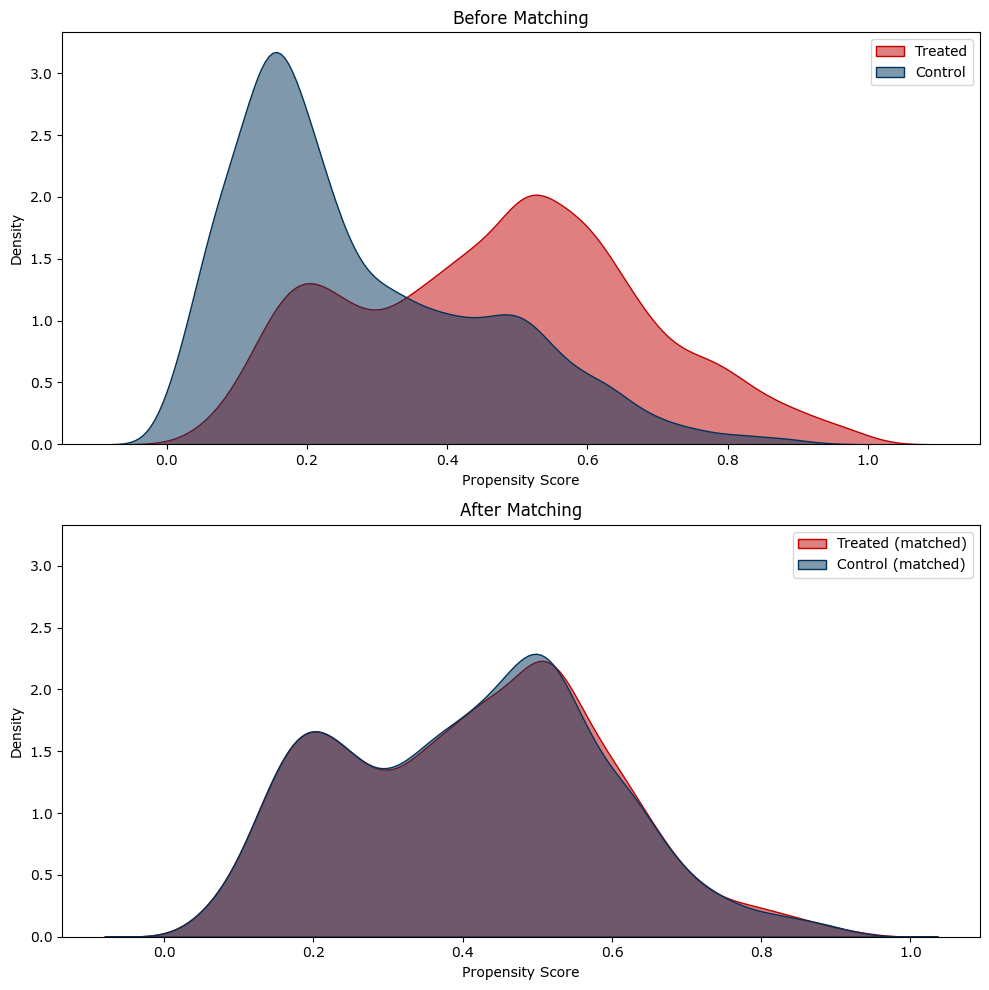

In [11]:
### Export pscores of full sample for stata visualizations
df_not_matched.to_csv(f'{DATA_DIR}pscores for visuals {TREATMENT_VAR}.csv')

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

# Before matching
sns.kdeplot(df_not_matched.loc[df_not_matched[TREATMENT_VAR]==1, 'pscore'], label='Treated', fill=True, color = TREATMENT_COLOR,common_norm=False, alpha=0.5, ax=axes[0])
sns.kdeplot(df_not_matched.loc[df_not_matched[TREATMENT_VAR]==0, 'pscore'], label='Control', fill=True, color = CONTROL_COLOR, common_norm=False, alpha=0.5, ax=axes[0])
axes[0].set_title('Before Matching')
axes[0].set_xlabel('Propensity Score')
axes[0].legend()

# After matching
sns.kdeplot(df_matched['treat_pscore'], label='Treated (matched)', fill=True, color = TREATMENT_COLOR, common_norm=False, alpha=0.5, ax=axes[1])
sns.kdeplot(df_matched['control_pscore'], label='Control (matched)', fill=True, color = CONTROL_COLOR, common_norm=False, alpha=0.5, ax=axes[1])
axes[1].set_title('After Matching')
axes[1].set_xlabel('Propensity Score')
axes[1].legend()

plt.tight_layout()
plt.show()

## Results

### Pooled Results - Financial Sustainability and Components

In [12]:
### Determine Variables of Interest for Financial Sustainability
variables_of_interest = ['SusScorestandardized', 'FiveYearGrowth_w', 'p_pct_w', 'C_w', 'ValuetoEquity2_w']
statistics = ['Mean Difference (ff-nff)', 'Mean Test Static', 'Median Difference (ff-nff)', 'Median Test Statistic', 'N (Matched Pairs)']

### Setup the output table
df_output_ATTs = pd.DataFrame(index = variables_of_interest, columns = statistics)

for var in variables_of_interest:
    treat_var = df_matched[f'treat_{var}']
    control_var = df_matched[f'control_{var}']

    ### Check Difference of Means
    t_stat, p_val = stats.ttest_rel(treat_var, control_var, nan_policy = 'omit')
    stars = ""
    if p_val <= 0.01:
        stars += "***"

    elif p_val <= 0.05:
        stars += "**"

    elif p_val <= 0.1:
        stars += "*"

    else:
        pass
        
    mean_diff = f'{np.mean(treat_var - control_var):.3f}'
    mean_diff += stars

    ### Check Difference of Medians
    stat, p_val = stats.wilcoxon(treat_var, control_var, nan_policy = 'omit')
    stars = ""
    if p_val <= 0.01:
        stars += "***"

    elif p_val <= 0.05:
        stars += "**"

    elif p_val <= 0.1:
        stars += "*"

    else:
        pass

    
    median_diff = f'{(treat_var.median() - control_var.median()):.3f}'
    median_diff += stars

    if var == 'SusScorestandardized':
        print(f'Treatment Median: {treat_var.median()}')
        print(f'Control Median: {control_var.median()}')
        
    ### Sample Count - Number of Matches
    n_count = len(df_matched)

    ### Set Values
    df_output_ATTs.loc[var, 'Mean Difference (ff-nff)'] = mean_diff
    df_output_ATTs.loc[var, 'Mean Test Static'] = t_stat
    df_output_ATTs.loc[var, 'Median Difference (ff-nff)'] = median_diff
    df_output_ATTs.loc[var, 'Median Test Statistic'] = stat
    df_output_ATTs.loc[var, 'N (Matched Pairs)'] = f'{n_count:.0f}'

df_output_ATTs

Treatment Median: 0.75
Control Median: 0.5


,Mean Difference (ff-nff),Mean Test Static,Median Difference (ff-nff),Median Test Statistic,N (Matched Pairs)
SusScorestandardized,0.027***,5.692995,0.250***,4894017.5,6252
FiveYearGrowth_w,0.002,0.312507,0.006,9744232.0,6252
p_pct_w,-0.902***,-10.591011,-0.186***,8481265.0,6252
C_w,0.147***,3.034251,0.054***,8760918.0,6252
ValuetoEquity2_w,0.554***,6.730018,0.295***,8262332.0,6252


### Treatment Effect of Financial Sustainability

In [13]:
treat_outcome = df_matched['treat_SusScorestandardized']
control_outcome = df_matched['control_SusScorestandardized']

print(treat_outcome.mean())

t_stat, p_val = stats.ttest_rel(treat_outcome, control_outcome, nan_policy='omit')

diff = treat_outcome - control_outcome
mean_diff = np.mean(diff)
se_diff = stats.sem(diff, nan_policy='omit')
ci_low, ci_high = stats.t.interval(0.95, len(diff.dropna())-1, loc=mean_diff, scale=se_diff)

print(f"ATT: {mean_diff:.3f}, 95% CI: [{ci_low:.3f}, {ci_high:.3f}]")

print(f"Mean (treated): {treat_outcome.mean():.3f}")
print(f"Mean (control): {control_outcome.mean():.3f}")
print(f"Paired t-test: t={t_stat:.3f}, p-value={p_val:.3g}")

0.6197616762635957
ATT: 0.027, 95% CI: [0.018, 0.037]
Mean (treated): 0.620
Mean (control): 0.593
Paired t-test: t=5.693, p-value=1.31e-08


### Year-by-year Analysis

In [14]:
# Create empty list to hold results for each year
results = []

# Make sure 'match_year' is in your df_matched and is numeric
years = sorted(df_matched['match_year'].unique())

for year in years:
    sub = df_matched[df_matched['match_year'] == year]
    treat_outcome = sub['treat_SusScorestandardized']
    control_outcome = sub['control_SusScorestandardized']
    diff = treat_outcome - control_outcome

    mean_treat = treat_outcome.mean()
    mean_control = control_outcome.mean()
    mean_diff = diff.mean()
    
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(treat_outcome, control_outcome, nan_policy='omit')

    results.append({
        'Year': year,
        'Mean Treatment': mean_treat,
        'Mean Control': mean_control,
        'Mean Difference': mean_diff,
        't-stat': t_stat,
        'p-value': p_val
    })

# Convert to DataFrame and pretty-print
table = pd.DataFrame(results).set_index('Year')
print(table.round(3))

      Mean Treatment  Mean Control  Mean Difference  t-stat  p-value
Year                                                                
2007           0.547         0.535            0.012   0.556    0.579
2008           0.599         0.539            0.060   3.207    0.001
2009           0.610         0.591            0.018   0.859    0.391
2010           0.592         0.595           -0.002  -0.125    0.901
2011           0.569         0.549            0.020   1.109    0.268
2012           0.596         0.561            0.035   1.890    0.060
2013           0.626         0.580            0.046   2.467    0.014
2014           0.641         0.600            0.041   2.163    0.031
2015           0.648         0.594            0.054   3.235    0.001
2016           0.638         0.602            0.036   2.175    0.030
2017           0.661         0.643            0.018   1.134    0.257
2018           0.672         0.647            0.026   1.616    0.107
2019           0.614         0.624

### Treatment Effect of Components of Financial Sustainability

In [15]:
treat_outcome = df_matched['treat_SusScorestandardized']
control_outcome = df_matched['control_SusScorestandardized']
t_stat, p_val = stats.ttest_rel(treat_outcome, control_outcome, nan_policy='omit')

diff = treat_outcome - control_outcome
mean_diff = np.mean(diff)
se_diff = stats.sem(diff, nan_policy='omit')
ci_low, ci_high = stats.t.interval(0.95, len(diff.dropna())-1, loc=mean_diff, scale=se_diff)

print(f"ATT: {mean_diff:.3f}, 95% CI: [{ci_low:.3f}, {ci_high:.3f}]")

print(f"Mean (treated): {treat_outcome.mean():.3f}")
print(f"Mean (control): {control_outcome.mean():.3f}")
print(f"Paired t-test: t={t_stat:.3f}, p-value={p_val:.3g}")

ATT: 0.027, 95% CI: [0.018, 0.037]
Mean (treated): 0.620
Mean (control): 0.593
Paired t-test: t=5.693, p-value=1.31e-08
